# NYC TAXI

The competition dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this playground competition. Based on individual trip attributes, participants should predict the duration of each trip in the test set.

File descriptions

* train.csv - the training set (contains 1458644 trip records)
* test.csv - the testing set (contains 625134 trip records)
* sample_submission.csv - a sample submission file in the correct format

Data fields

* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server:
 ** Y=store and forward; N=not a store and forward trip.**
* trip_duration - duration of the trip in seconds

Disclaimer: The decision was made to not remove dropoff coordinates from the dataset order to provide an expanded set of variables to use in Kernels.

In [116]:
import pandas as pd  #pandas for using dataframe and reading csv 
import numpy as np   #numpy for vector operations and basic maths 
#import simplejson    #getting JSON in simplified format
import urllib        #for url stuff
#import gmaps       #for using google maps to visulalize places on maps
import re            #for processing regular expressions
import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import matplotlib.pyplot as plt # for plotting basic graphs and pie charts
import time          #to get the system time
import scipy         #for other dependancies
from sklearn.cluster import KMeans # for doing K-means clustering
from haversine import haversine # for calculating haversine distance
import math          #for basic maths operations
import seaborn as sns #for making plots
import matplotlib.pyplot as plt # for plotting
import os  # for os commands
from scipy.misc import imread, imresize, imsave  # for plots 
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [51]:
# Creating the INPUT FOLDER which will contain our input files!
INPUT_FOLDER='/Users/as186194/Documents/DOCUMENTS/TRIALS/Kaggle/Kaggle_NYC_Taxi/'
print ('File Sizes:')
for f in os.listdir(INPUT_FOLDER):
    if 'zip' not in f:
       print (f.ljust(30) + str(round(os.path.getsize(INPUT_FOLDER +  f) / 1000000, 2)) + ' MB')

File Sizes:
.DS_Store                     0.01 MB
NYC_Taxi.pptx                 0.61 MB
test.csv                      70.79 MB
train.csv                     200.59 MB


In [52]:
train_df=pd.read_csv(INPUT_FOLDER + 'train.csv')

In [53]:
test_df=pd.read_csv(INPUT_FOLDER + 'test.csv')

In [54]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [55]:
train_df.shape

(1458644, 11)

In [56]:
train_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [57]:
test_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [58]:
test_df.shape

(625134, 9)

In [59]:
test_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')

Convert N and Y from 'store_and_fwd_flag' to 0 and 1 respectively

In [60]:
#train_df["store_and_fwd_flag"].replace(['N','Y'],[0,1],inplace=True)

In [106]:
vendor

vendor_id
1    678342
2    780302
dtype: int64

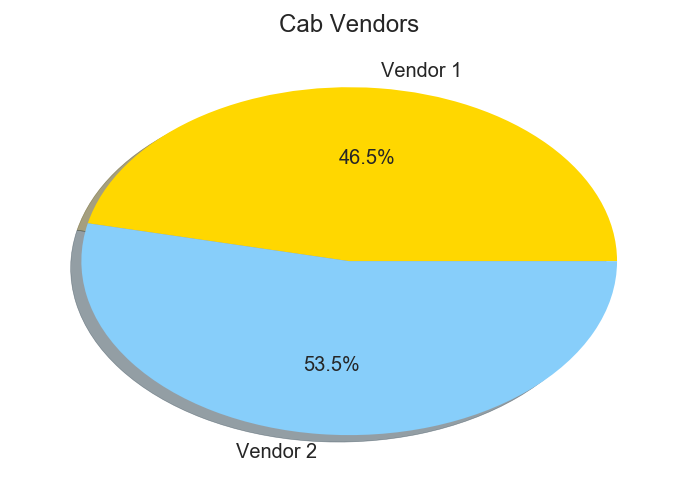

In [121]:
vendor=train_df.groupby("vendor_id").size()

colors = ['gold', 'lightskyblue']
plt.pie(vendor, shadow = True, colors = colors, labels = ['Vendor 1', 'Vendor 2'],
        autopct='%1.1f%%')
plt.title('Cab Vendors')

In [70]:
duration=train_df.groupby('trip_duration').size()

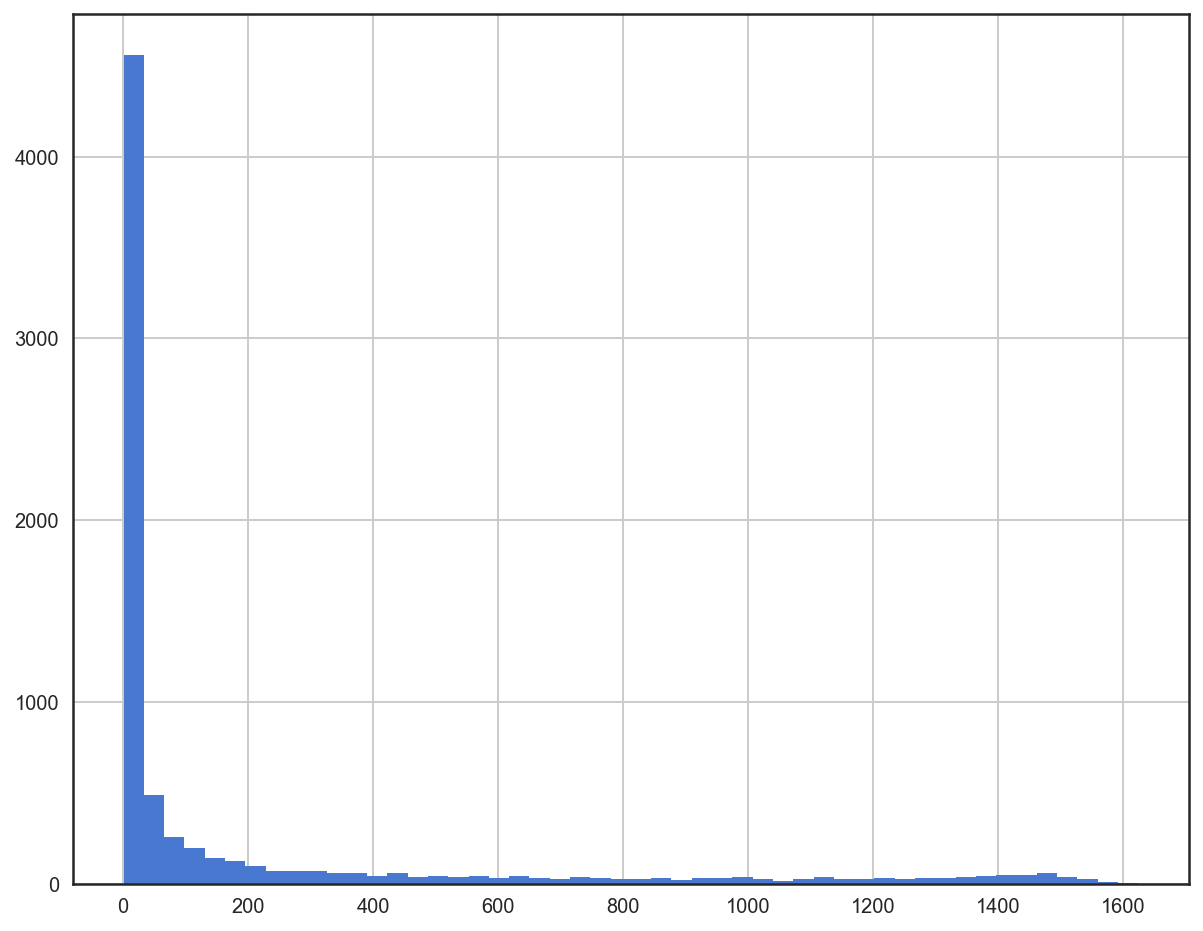

In [82]:
duration.hist(bins=50,figsize=(10,8))

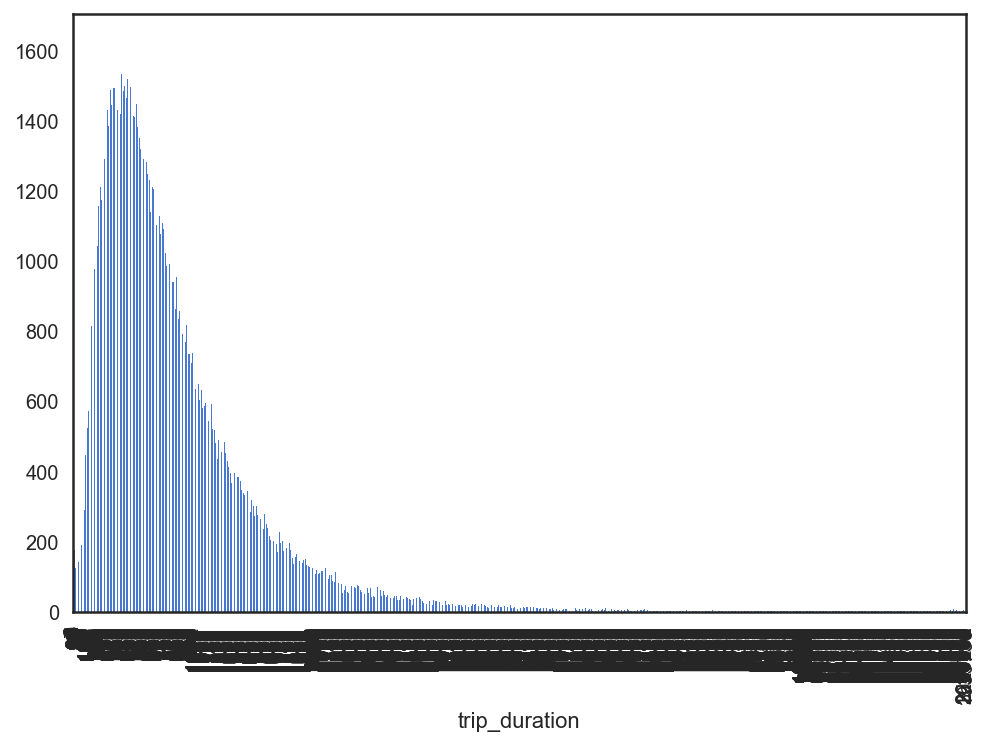

In [69]:
duration.plot(kind='bar')
plt.show()

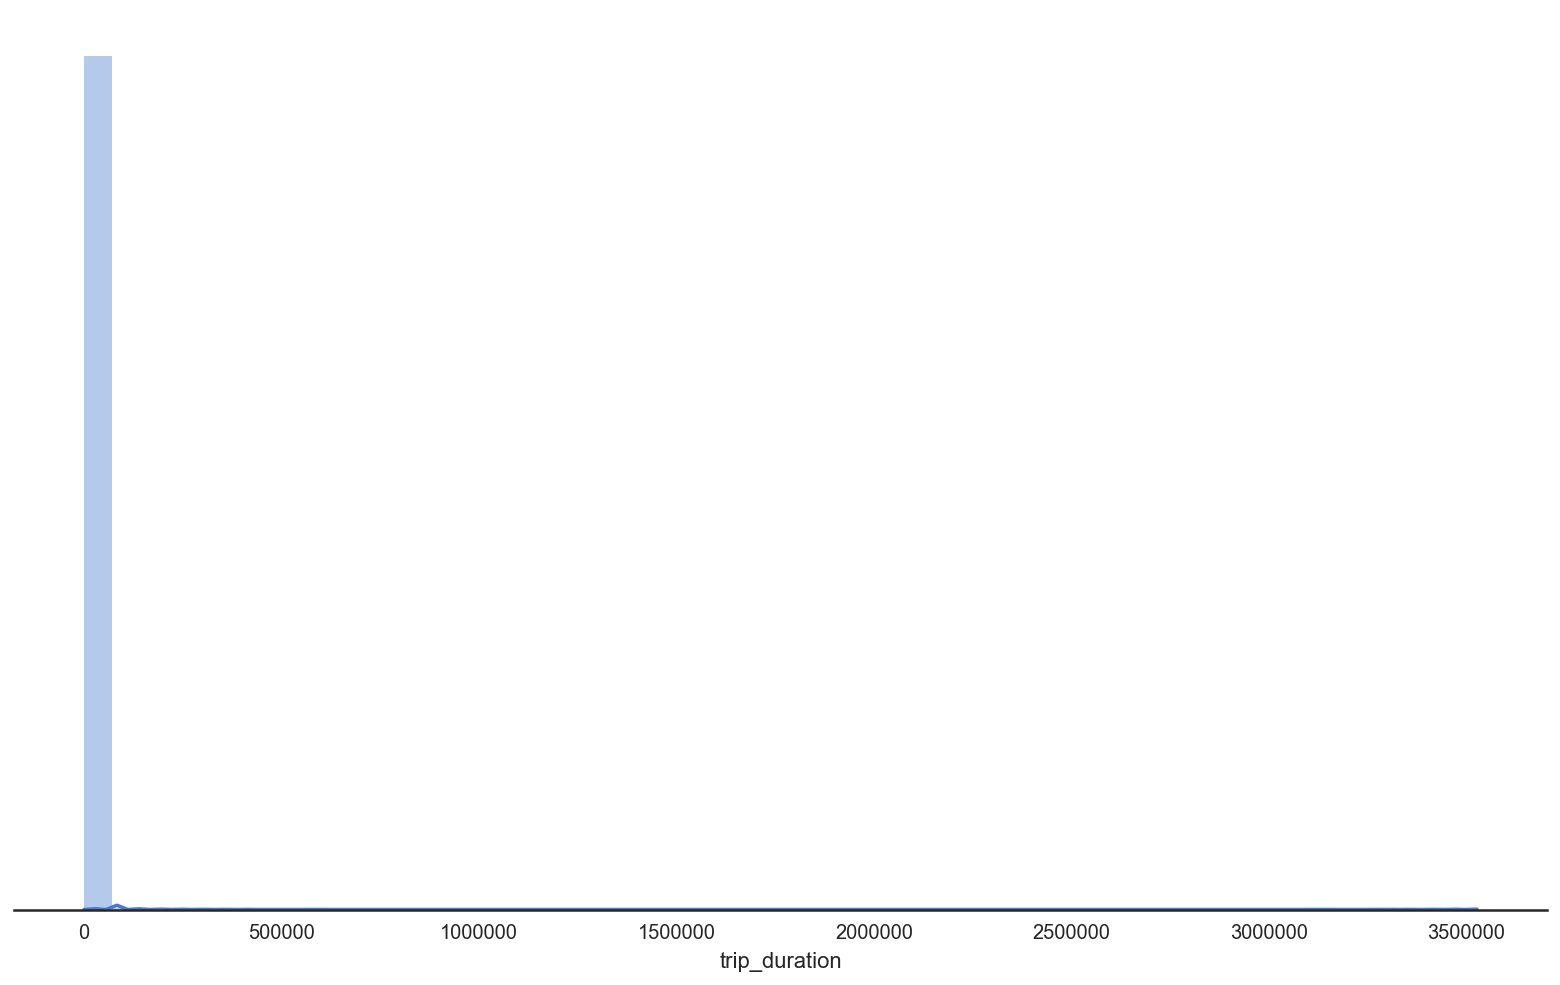

In [84]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot((train_df['trip_duration'].values+1), 
axlabel = 'trip_duration', label = 'trip_duration', bins=50)
plt.setp(axes, yticks=[])
plt.tight_layout()

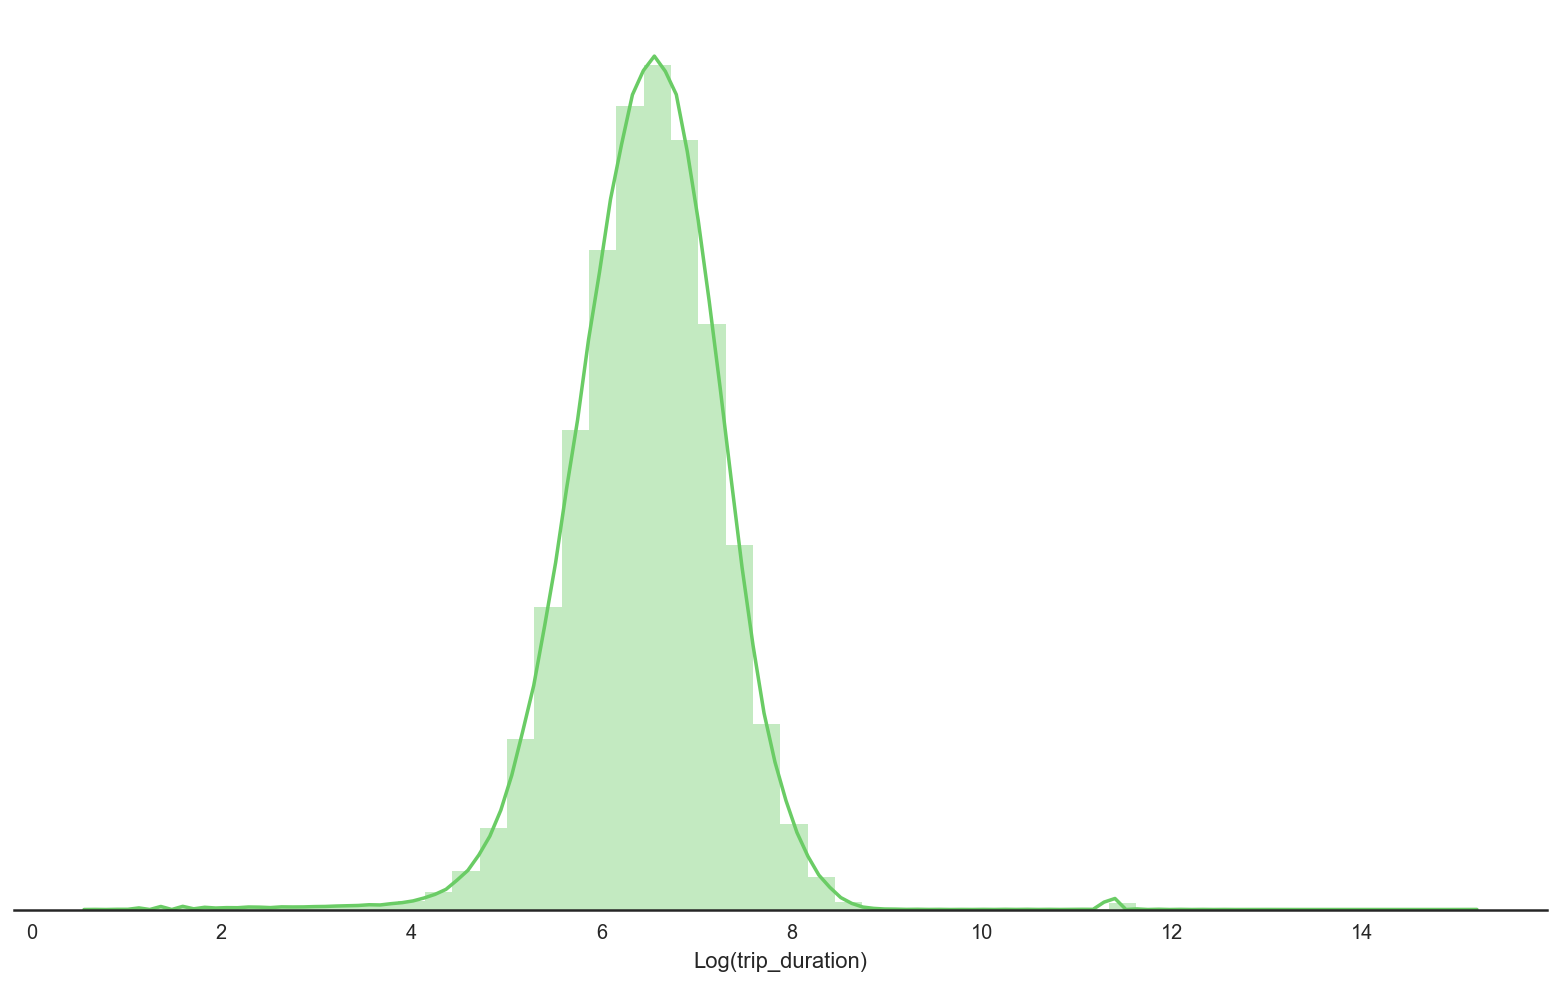

In [83]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(train_df['trip_duration'].values+1),
             axlabel = 'Log(trip_duration)', label = 'log(trip_duration)', bins = 50, color="g")
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()

**Findings** - The above histrogram and kernel density plot that the trip-durations are like gaussian and few trips have very large duration, like ~350000 seconds which is 100 hours, while most of the trips are: 
* e^4 = 1 minute to 
* e^8 ~ 60 minutes 

Probably trips are taken inside Manhattan or in New York only.

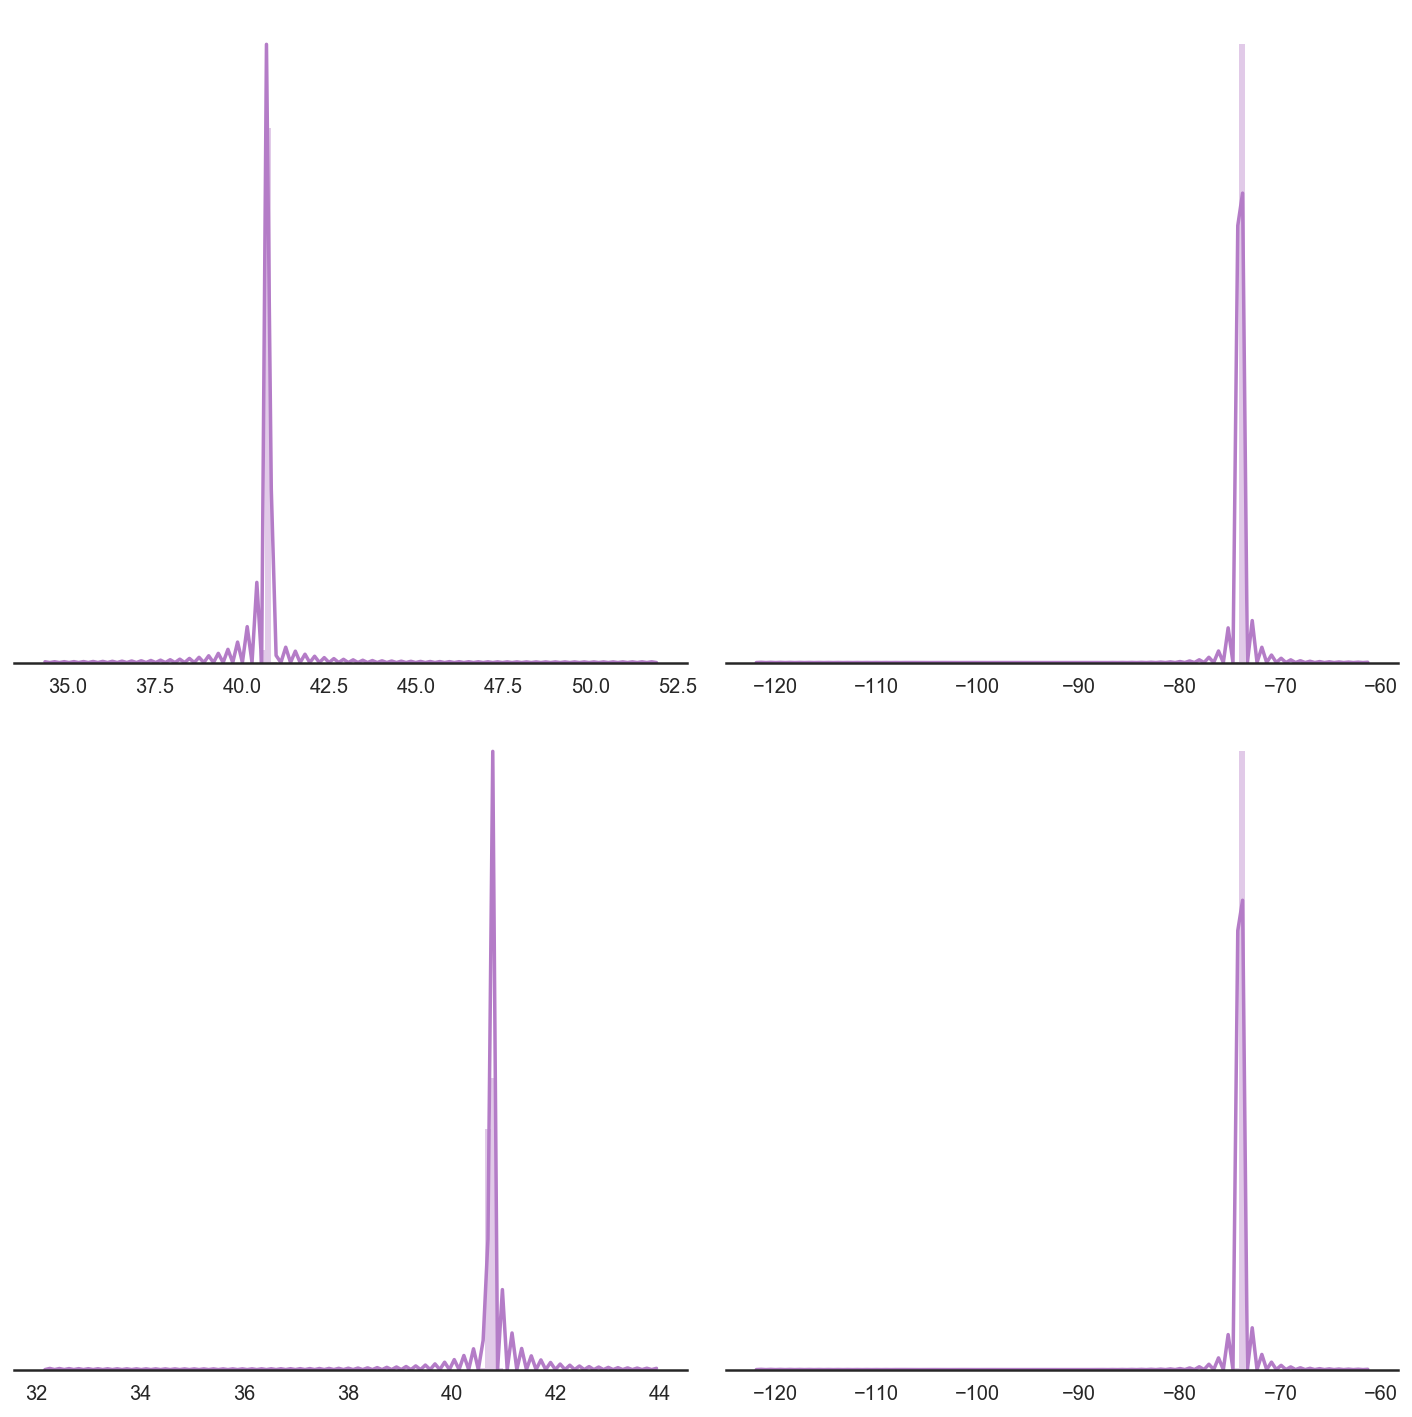

In [86]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(train_df['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train_df['pickup_longitude'].values, label = 'pickup_longitude',color="m",bins =100, ax=axes[0,1])
sns.distplot(train_df['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train_df['dropoff_longitude'].values, label = 'dropoff_longitude',color="m",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

**Findings** - From the plot above it is clear that pick and drop latitude are centered around *40 to 41*, and longitude are situated around *-74 to -73*. 

We are not getting any histogram kind of plots when we are plotting lat - long as the distplot frunction of sns is getting affacted by outliers, trips which are very far from each other like lat 32 to lat 44, are taking very long time, and affacted this plot such that it is coming of as a spike. 


Let's remove those large duration trip by using a cap on lat-long and visulaize the distributions of latitude and longitude given to us.

1452385 1452385


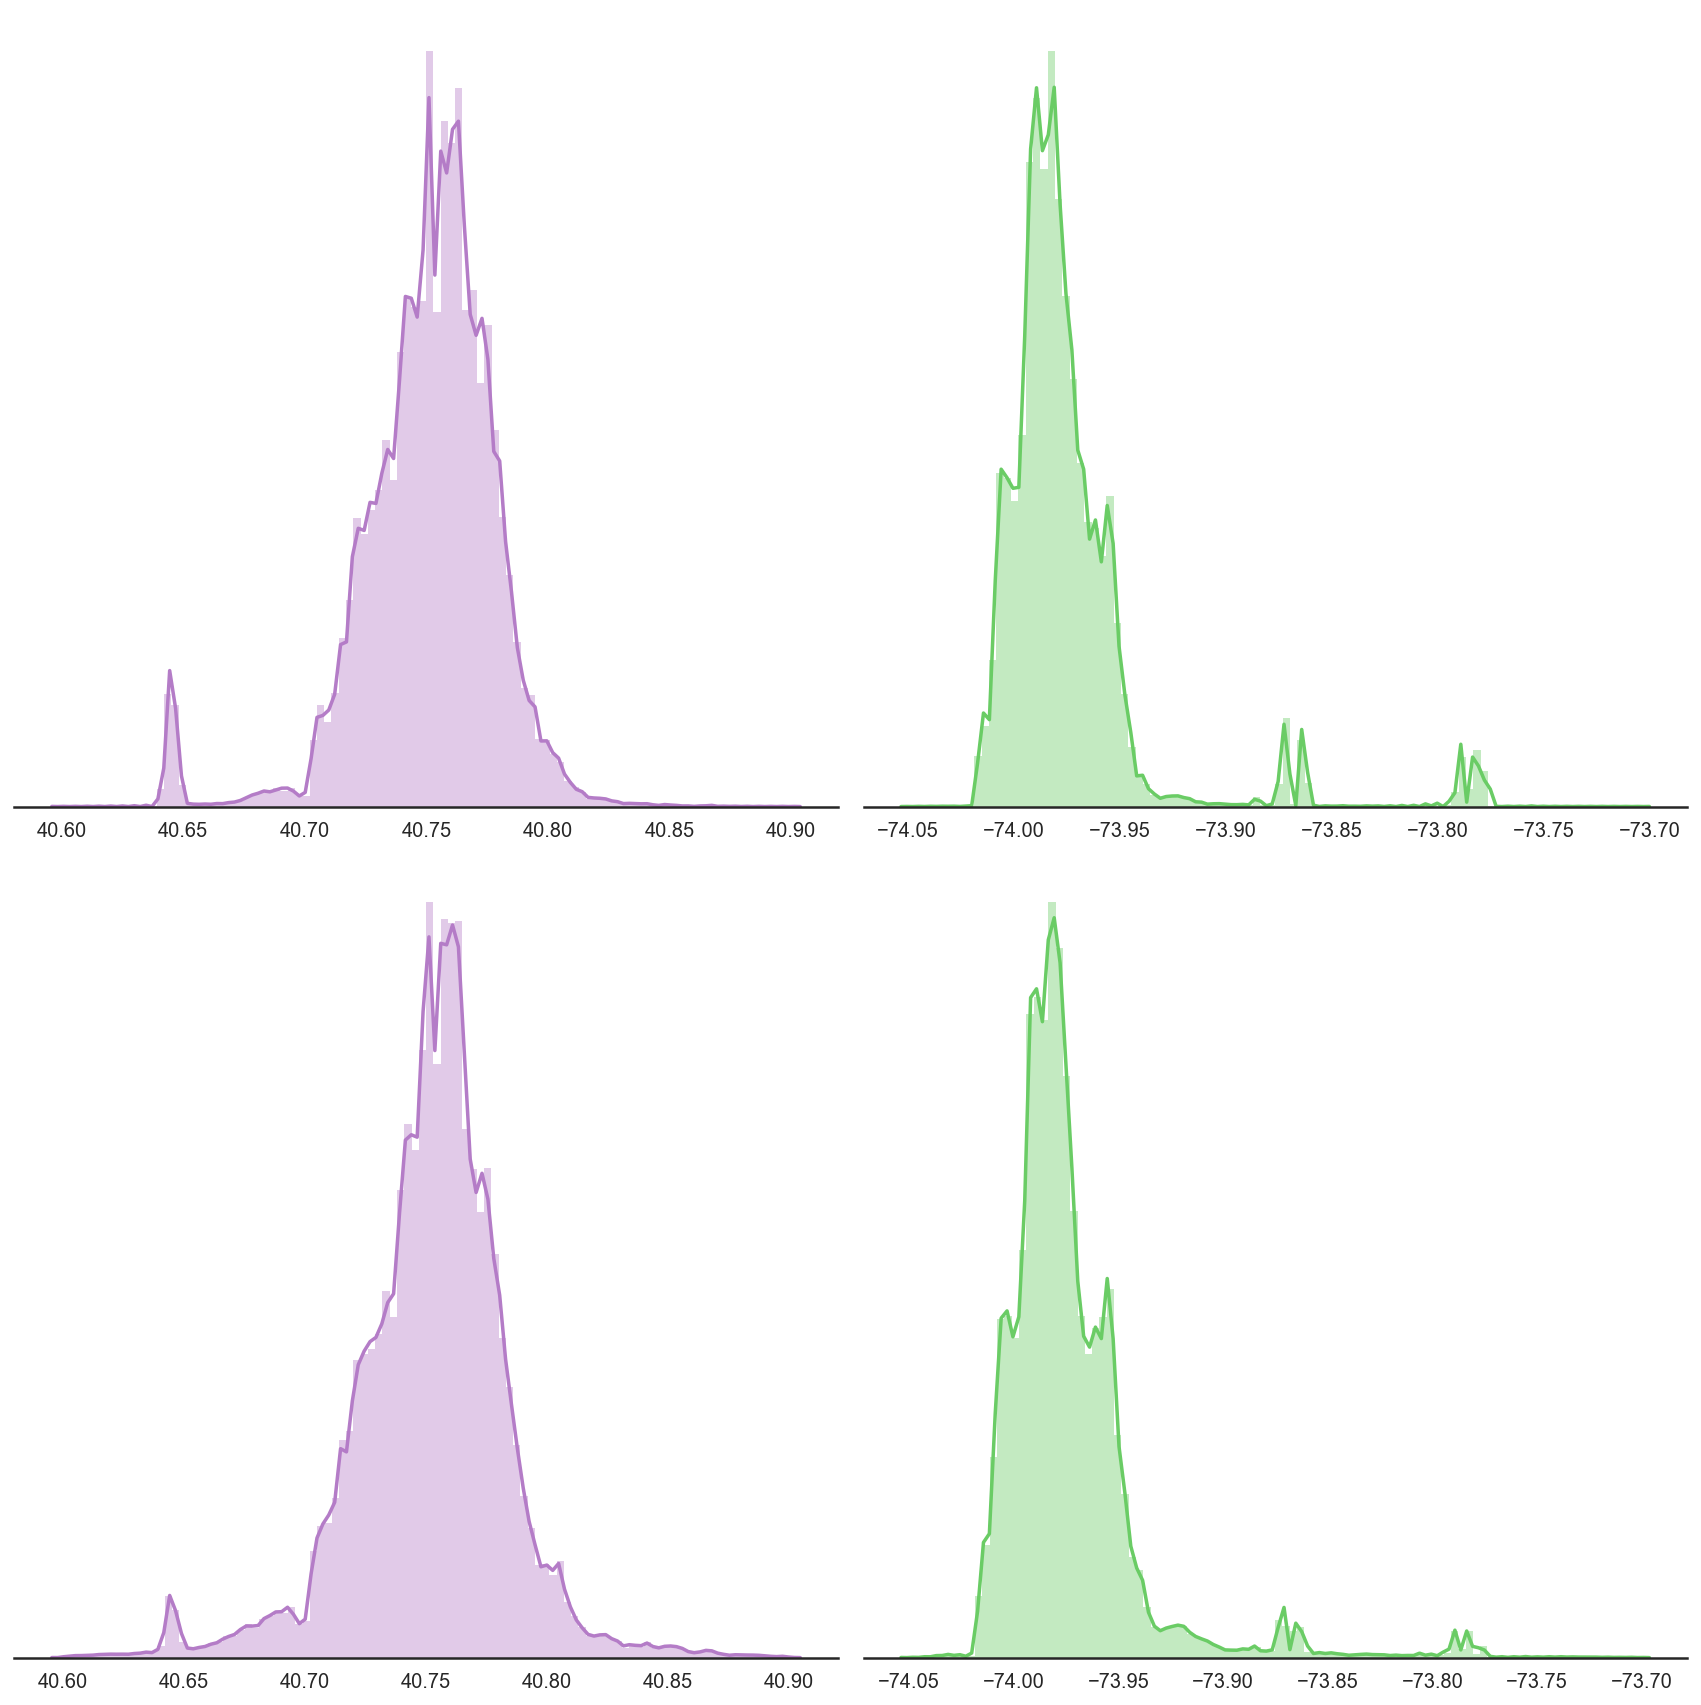

In [99]:
df = train_df.loc[(train_df.pickup_latitude > 40.6) & (train_df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
train_data = df.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(12, 12), sharex=False, sharey = False)#
sns.despine(left=True)

sns.distplot(train_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="g",bins =100, ax=axes[0,1])
sns.distplot(train_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="g",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()


print(df.shape[0], train_data.shape[0])
plt.show()

As we put the following caps on lat-long -

* latitude should be between 40.6 to 40.9
* longitude should be between -74.05 to -73.70

We get that the distribution spikes becomes as distribution in distplot (distplot is a histrogram plot in seaborn package), we can see that most of the trips are getting concentrated between these lat-long only. Lets plot them on an empty image and check what kind of a city map we are getting as we can't use gmaps and folium on kaggle kernel for visualizations.

In [100]:
train_data['pickup_datetime'] = pd.to_datetime(train_data.pickup_datetime)
train_data.loc[:, 'pick_date'] = train_data['pickup_datetime'].dt.date
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pick_date
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26
